#### TOTA Population

In [8]:
### Use Data from census subdivisions (smallest territorial division) for Census 2016
### Cross with map of economic regions
### Cross with map of tourism regions
### Get populaton estimates for each region for 2016

In [1]:
import pandas as pd 
import geopandas as gpd
import getpass
import requests
import shapely.wkb 
import subprocess
import os
import zipfile
import glob
import matplotlib.pyplot as plt

In [2]:
census = gpd.read_file(f'../data/raw/BCGW_7113060B_1631519005190_12620/CEN_PROF_DETAILED_CSD_ATTRS_SP.geojson')

In [20]:
list(census.columns)

['CEN_CPCCS_SYSID',
 'CENSUS_YEAR',
 'CENSUS_SUBDIVISION_ID',
 'CENSUS_SUBDIVISION_NAME',
 'GLOBAL_NONRESP_SF_PCT',
 'GLOBAL_NONRESP_LF_PCT',
 'COMMUTE_TOTAL_BY_MODE',
 'COMMUTE_CAR_DRIVER',
 'COMMUTE_CAR_PASSENGER',
 'COMMUTE_PUBLIC_TRANSIT',
 'COMMUTE_WALK',
 'COMMUTE_BICYCLE',
 'COMMUTE_TOTAL_BY_DURATION',
 'COMMUTE_DURTN_0_14',
 'COMMUTE_DURTN_15_29',
 'COMMUTE_DURTN_30_44',
 'COMMUTE_DURTN_45_59',
 'COMMUTE_DURTN_60PLUS',
 'EDUCATION_15PLUS_UNDER_GR12',
 'EDUCATION_15PLUS_GR12',
 'EDUCATION_15PLUS_POSTSEC',
 'EDUCATION_15PLUS_APPRENTICE',
 'EDUCATION_15PLUS_COLLEGE_CERT',
 'EDUCATION_15PLUS_UNIV_BLW_BACH',
 'EDUCATION_15PLUS_UNIV_BACHELOR',
 'EDUCATION_15PLUS_UNIV_MASTER',
 'EDUCATION_15PLUS_UNIV_DOCTOR',
 'EDUCATION_25_64_UNDER_GR12',
 'EDUCATION_25_64_GR12',
 'EDUCATION_25_64_POSTSEC',
 'EDUCATION_25_64_APPRENTICE',
 'EDUCATION_25_64_COLLEGE_CERT',
 'EDUCATION_25_64_UNIV_BLW_BACH',
 'EDUCATION_25_64_UNIV_BACHELOR',
 'EDUCATION_25_64_UNIV_MASTER',
 'EDUCATION_25_64_UNIV_DOCTOR',


In [4]:
#census_map = gpd.read_file(f'../data/raw/BCGW_7113060B_1627367115435_3236/CEN_CENSUS_SUBDIVSIONS_SVW.geojson')

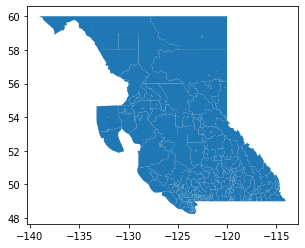

In [4]:
census.plot()

In [5]:
### Regions
tour = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
econ = gpd.read_file('../data/raw/BCGW_7113060B_1628167339306_10764/CEN_ECONOMIC_REGIONS_SVW.geojson')

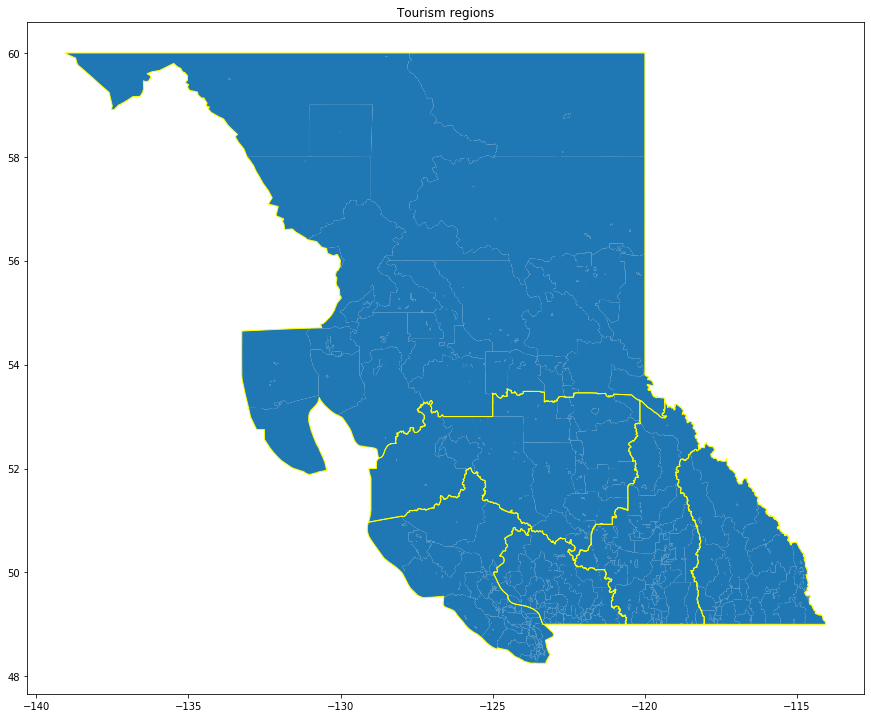

In [6]:
fig, ax = plt.subplots(figsize =(15,15))
census.plot(ax=ax)
tour.plot(ax=ax, color="None", edgecolor='yellow')
plt.title("Tourism regions")
plt.show()

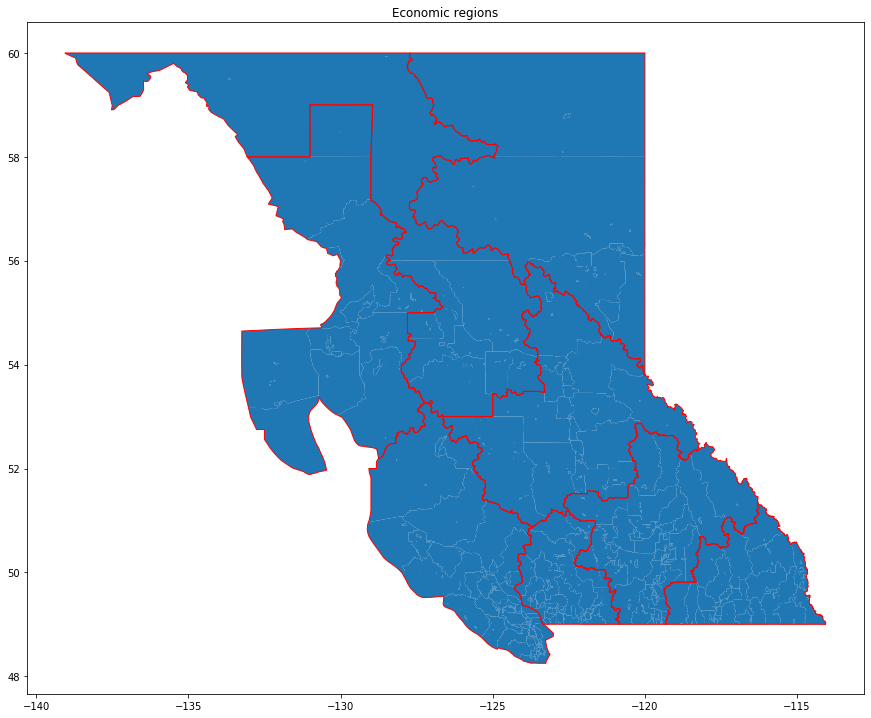

In [7]:
fig, ax = plt.subplots(figsize =(15,15))
census.plot(ax=ax)
econ.plot(ax=ax, color="None", edgecolor='red')
plt.title("Economic regions")
plt.show()

In [8]:
correspondence = {'Vancouver Island and Coast / Île de Vancouver et la côte':'vancouver_island_and_coast',
                 'Lower Mainland--Southwest / Lower Mainland--Sud-ouest':'lower_mainland_southwest',
                 'Thompson--Okanagan':'thompson_okanagan',
                 'Kootenay':'kootenay',
                 'Cariboo':'cariboo',
                 'North Coast / Côte-nord':'north_coast',
                 'Nechako':'nechako',
                 'Northeast / Nord-est':'northeast'}

In [9]:
econ['ECONOMIC_REGION_NAME_slug']= econ['ECONOMIC_REGION_NAME'].map(correspondence)

In [10]:
census_r1 = gpd.sjoin(census[['CENSUS_SUBDIVISION_NAME','POP_TOTAL_2016','POP_TOTAL_2011','geometry']], tour[['TOURISM_REGION_NAME','geometry']], how ='inner').drop(columns='index_right')
census_r2 = gpd.sjoin(census_r1, econ[['ECONOMIC_REGION_NAME','ECONOMIC_REGION_NAME_slug','geometry']], how ='inner').drop(columns='index_right')

In [11]:
census_r2.head()

,CENSUS_SUBDIVISION_NAME,POP_TOTAL_2016,POP_TOTAL_2011,geometry,TOURISM_REGION_NAME,ECONOMIC_REGION_NAME,ECONOMIC_REGION_NAME_slug
0,Nanaimo B,4033.0,4045.0,"POLYGON ((-123.75663 49.21174, -123.79512 49.2...",vancouver_island,Vancouver Island and Coast / Île de Vancouver ...,vancouver_island_and_coast
1,Nanaimo C,2808.0,2834.0,"MULTIPOLYGON (((-124.63753 49.28484, -124.6568...",vancouver_island,Vancouver Island and Coast / Île de Vancouver ...,vancouver_island_and_coast
2,Nanaimo F,7724.0,7422.0,"POLYGON ((-124.66570 49.29973, -124.66675 49.2...",vancouver_island,Vancouver Island and Coast / Île de Vancouver ...,vancouver_island_and_coast
3,Nanaimo G,7465.0,7158.0,"MULTIPOLYGON (((-124.36049 49.41126, -124.3722...",vancouver_island,Vancouver Island and Coast / Île de Vancouver ...,vancouver_island_and_coast
4,Alberni-Clayoquot D,1616.0,1701.0,"POLYGON ((-125.33101 49.56738, -125.36162 49.5...",vancouver_island,Vancouver Island and Coast / Île de Vancouver ...,vancouver_island_and_coast


### Get population estimates by region

In [12]:
census_r2.columns

Index(['CENSUS_SUBDIVISION_NAME', 'POP_TOTAL_2016', 'POP_TOTAL_2011',
       'geometry', 'TOURISM_REGION_NAME', 'ECONOMIC_REGION_NAME',
       'ECONOMIC_REGION_NAME_slug'],
      dtype='object')

In [16]:
census_r2.groupby('TOURISM_REGION_NAME').sum().reset_index()

,TOURISM_REGION_NAME,POP_TOTAL_2016,POP_TOTAL_2011
0,cariboo_chilcotin_coast,155587.0,156895.0
1,kootenay_rockies,192109.0,186460.0
2,northern_british_columbia,329276.0,325567.0
3,thompson_okanagan,638502.0,612076.0
4,vancouver_coast_and_mountains,2976039.0,2796123.0
5,vancouver_island,861737.0,814963.0


In [15]:
census_r2.groupby('ECONOMIC_REGION_NAME_slug').sum().reset_index()

,ECONOMIC_REGION_NAME_slug,POP_TOTAL_2016,POP_TOTAL_2011
0,cariboo,243894.0,241959.0
1,kootenay,191425.0,185673.0
2,lower_mainland_southwest,2931013.0,2752727.0
3,nechako,77193.0,78353.0
4,north_coast,65936.0,66349.0
5,northeast,79397.0,77185.0
6,thompson_okanagan,640183.0,613926.0
7,vancouver_island_and_coast,924209.0,875912.0


In [19]:
census_r2.groupby('ECONOMIC_REGION_NAME_slug').sum().reset_index().to_csv(f"../data/processed/population_by_economic_region.csv")
census_r2.groupby('TOURISM_REGION_NAME').sum().reset_index().to_csv(f"../data/processed/population_by_tourism_region.csv")

In [17]:
dev.to_file(f"../data/processed/CEN_ECONOMIC_REGIONS_SVW_region.geojson", driver="GeoJSON")

NameError: name 'dev' is not defined